In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-cities-reviews/london_test.csv
/kaggle/input/airbnb-cities-reviews/london_neighbourhoods.geojson
/kaggle/input/airbnb-cities-reviews/london_train.csv
/kaggle/input/airbnb-cities-reviews/nyc_test.csv
/kaggle/input/airbnb-cities-reviews/london_preprocessed.csv
/kaggle/input/airbnb-cities-reviews/nyc_preprocessed.csv
/kaggle/input/airbnb-cities-reviews/nyc_neighbourhoods.geojson
/kaggle/input/airbnb-cities-reviews/nyc_train.csv
/kaggle/input/airbnb-cities-reviews/nyc_listings.csv/listings.csv
/kaggle/input/airbnb-cities-reviews/london_listings.csv/listings.csv


In [3]:
pip install datasets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load CSV files
train_df_london = pd.read_csv('/kaggle/input/airbnb-cities-reviews/london_train.csv')
train_df_nyc = pd.read_csv('/kaggle/input/airbnb-cities-reviews/nyc_train.csv')
test_df_london = pd.read_csv('/kaggle/input/airbnb-cities-reviews/london_test.csv')
test_df_nyc = pd.read_csv('/kaggle/input/airbnb-cities-reviews/nyc_test.csv')

In [5]:
train_df_london = train_df_london[['comments', 'polarity_class']]
train_df_nyc = train_df_nyc[['comments', 'polarity_class']]
test_df_london = test_df_london[['comments', 'polarity_class']]
test_df_nyc = test_df_nyc[['comments', 'polarity_class']]

In [6]:
train_df = pd.concat([train_df_london, train_df_nyc], ignore_index=True)
test_df = pd.concat([test_df_london, test_df_nyc], ignore_index=True)

In [7]:
train_df['polarity_class'] = train_df['polarity_class'].astype(int)
test_df['polarity_class'] = test_df['polarity_class'].astype(int)

In [14]:
positive_examples = train_df[train_df['polarity_class'] == 1]
negative_examples = train_df[train_df['polarity_class'] == 0]

# Downsample positive examples
positive_examples_downsampled = positive_examples.sample(n=len(negative_examples), random_state=42)

# Combine the downsampled positive examples with the negative examples
train_df = pd.concat([positive_examples_downsampled, negative_examples])

In [18]:
positive_examples = test_df[test_df['polarity_class'] == 1]
negative_examples = test_df[test_df['polarity_class'] == 0]

# Downsample positive examples
positive_examples_downsampled = positive_examples.sample(n=len(negative_examples), random_state=42)

# Combine the downsampled positive examples with the negative examples
test_df = pd.concat([positive_examples_downsampled, negative_examples])

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188282 entries, 292145 to 1990485
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   comments        188282 non-null  object
 1   polarity_class  188282 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [19]:
import pandas as pd
from datasets import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_dict({'text': train_df["comments"], 'label': train_df["polarity_class"]})
test_dataset = Dataset.from_dict({'text': test_df["comments"], 'label': test_df["polarity_class"]})

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Preprocess data
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=100)

encoded_train_dataset = train_dataset.map(preprocess_function, batched=True, batch_size=1024, num_proc=4)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True, batch_size=1024, num_proc=4)

Map (num_proc=4):   0%|          | 0/188282 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/47070 [00:00<?, ? examples/s]

In [20]:
encoded_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
encoded_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [25]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    report_to=[],
    fp16=True,
)

# Initialize Trainer
trainer1 = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=tokenizer,
)

# Train model
trainer1.train()

# Evaluate model
metrics = trainer1.evaluate()
print(metrics)

# Save model
model.save_pretrained('./fine-tuned-distilbert')
tokenizer.save_pretrained('./fine-tuned-distilbert')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.118200
1000,0.080700


{'eval_loss': 0.06801938265562057, 'eval_runtime': 73.8736, 'eval_samples_per_second': 637.169, 'eval_steps_per_second': 4.981, 'epoch': 1.0}


('./fine-tuned-distilbert/tokenizer_config.json',
 './fine-tuned-distilbert/special_tokens_map.json',
 './fine-tuned-distilbert/vocab.txt',
 './fine-tuned-distilbert/added_tokens.json')

In [34]:
!zip -r fine-tuned-distilbert.zip /kaggle/working/fine-tuned-distilbert

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/fine-tuned-distilbert/ (stored 0%)
  adding: kaggle/working/fine-tuned-distilbert/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/fine-tuned-distilbert/config.json (deflated 46%)
  adding: kaggle/working/fine-tuned-distilbert/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/fine-tuned-distilbert/vocab.txt (deflated 53%)
  adding: kaggle/working/fine-tuned-distilbert/model.safetensors (deflated 8%)


In [30]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Evaluate the model on the test set
predictions, labels, _ = trainer1.predict(encoded_test_dataset)
preds = np.argmax(predictions, axis=1)

# Compute metrics
micro_f1 = f1_score(labels, preds, average='weighted')
balanced_acc = accuracy_score(labels, preds)
conf_matrix = confusion_matrix(labels, preds)

print(f"Test Weighted-F1 Score: {micro_f1}")
print(f"Test Balanced Accuracy: {balanced_acc}")
print(f"Test Confusion Matrix:\n{conf_matrix}")

Test Weighted-F1 Score: 0.975439794828277
Test Balanced Accuracy: 0.9754408328022095
Test Confusion Matrix:
[[23110   425]
 [  731 22804]]


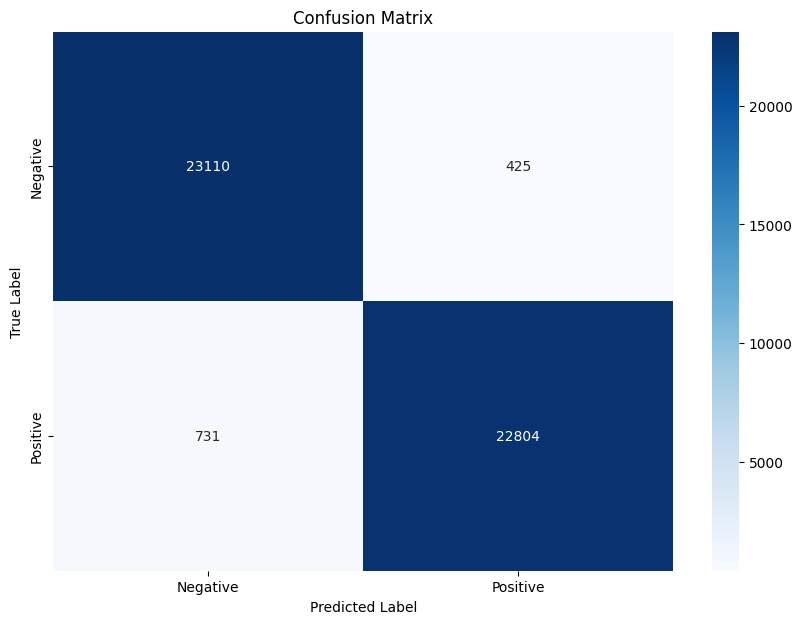

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
pip install geopandas folium matplotlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


# Get neighborhood for each listing

In [115]:
# Load CSV files
train_df_london = pd.read_csv('/kaggle/input/airbnb-cities-reviews/london_train.csv')
train_df_nyc = pd.read_csv('/kaggle/input/airbnb-cities-reviews/nyc_train.csv')
test_df_london = pd.read_csv('/kaggle/input/airbnb-cities-reviews/london_test.csv')
test_df_nyc = pd.read_csv('/kaggle/input/airbnb-cities-reviews/nyc_test.csv')

In [116]:
train_df_london = train_df_london[['listing_url','comments', 'polarity_class']]
train_df_nyc = train_df_nyc[['listing_url','comments', 'polarity_class']]
test_df_london = test_df_london[['listing_url','comments', 'polarity_class']]
test_df_nyc = test_df_nyc[['listing_url','comments', 'polarity_class']]

In [118]:
london_df = pd.concat([train_df_london, test_df_london], ignore_index=True)
nyc_df = pd.concat([train_df_nyc, test_df_nyc], ignore_index=True)

In [119]:
london_df['polarity_class'] = london_df['polarity_class'].astype(int)
nyc_df['polarity_class'] = nyc_df['polarity_class'].astype(int)

In [120]:
positive_examples = london_df[london_df['polarity_class'] == 1]
negative_examples = london_df[london_df['polarity_class'] == 0]

# Downsample positive examples
positive_examples_downsampled = positive_examples.sample(n=len(negative_examples), random_state=42)

# Combine the downsampled positive examples with the negative examples
london_df = pd.concat([positive_examples_downsampled, negative_examples])

In [121]:
positive_examples = nyc_df[nyc_df['polarity_class'] == 1]
negative_examples = nyc_df[nyc_df['polarity_class'] == 0]

# Downsample positive examples
positive_examples_downsampled = positive_examples.sample(n=len(negative_examples), random_state=42)

# Combine the downsampled positive examples with the negative examples
nyc_df = pd.concat([positive_examples_downsampled, negative_examples])

In [ ]:
all_listings_nyc = pd.read_csv('/kaggle/input/airbnb-cities-reviews/nyc_listings.csv/listings.csv')
all_listings_london = pd.read_csv('/kaggle/input/airbnb-cities-reviews/london_listings.csv/listings.csv')

In [122]:
all_listings = pd.concat([all_listings_nyc, all_listings_london])

In [123]:
london_df  =london_df.merge(all_listings[['listing_url', 'neighbourhood_cleansed']], on='listing_url', how='left')

In [124]:
london_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162264 entries, 0 to 162263
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   listing_url             162264 non-null  object
 1   comments                162264 non-null  object
 2   polarity_class          162264 non-null  int64 
 3   neighbourhood_cleansed  162264 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [125]:
nyc_df  =nyc_df.merge(all_listings[['listing_url', 'neighbourhood_cleansed']], on='listing_url', how='left')

In [126]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73088 entries, 0 to 73087
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   listing_url             73088 non-null  object
 1   comments                73088 non-null  object
 2   polarity_class          73088 non-null  int64 
 3   neighbourhood_cleansed  73088 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


In [127]:
nyc_df.head()

,listing_url,comments,polarity_class,neighbourhood_cleansed
0,https://www.airbnb.com/rooms/50170583,"We loved the place.. it’s was clean, comfortab...",1,Prospect-Lefferts Gardens
1,https://www.airbnb.com/rooms/21461282,The beautiful place is so close to the stores ...,1,Concourse Village
2,https://www.airbnb.com/rooms/20177584,"Daniel's place is homey, stylish, and comforta...",1,Williamsburg
3,https://www.airbnb.com/rooms/567271244171571875,This spot is a jewel! If you want to be in a h...,1,Bushwick
4,https://www.airbnb.com/rooms/873392253229649061,"It was a very nice place to stay in, very comf...",1,East New York


# London

In [ ]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('//kaggle/working/fine-tuned-distilbert')
model.to(device)  # Move model to GPU
model.eval()

# Tokenize function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=100)

# Prediction function
def predict_batch(texts):
    tokens = tokenize_function(texts)
    # Move tensors to GPU
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions

# Apply tokenization and prediction in batches
batch_size = 128
num_batches = len(london_df) // batch_size + int(len(london_df) % batch_size != 0)

predictions = []
for i in range(num_batches):
    batch_texts = london_df['comments'].iloc[i*batch_size:(i+1)*batch_size].tolist()
    batch_predictions = predict_batch(batch_texts)
    predictions.extend(batch_predictions.cpu().tolist())  
    
    # Print progress
    progress = (i + 1) / num_batches * 100
    print(f"Processed batch {i + 1}/{num_batches} ({progress:.2f}%)")

# Add predictions to the dataframe
london_df['predicted_label'] = predictions


In [139]:
london_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162264 entries, 0 to 162263
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   listing_url             162264 non-null  object
 1   comments                162264 non-null  object
 2   polarity_class          162264 non-null  int64 
 3   neighbourhood_cleansed  162264 non-null  object
 4   predicted_label         162264 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.2+ MB


In [140]:
# Calculate average predicted label per neighborhood
sentiment_per_neighborhood = london_df.groupby('neighbourhood_cleansed')['predicted_label'].mean().reset_index()

# Rename columns for clarity
sentiment_per_neighborhood.columns = ['neighborhood', 'sentiment']

In [172]:
sentiment_per_neighborhood.head(40)

,neighborhood,sentiment
0,Barking and Dagenham,0.474922
1,Barnet,0.557573
2,Bexley,0.532319
3,Brent,0.436666
4,Bromley,0.576159
5,Camden,0.449978
6,City of London,0.452618
7,Croydon,0.476654
8,Ealing,0.556539
9,Enfield,0.588348


In [161]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
from folium import Choropleth

#  Load geographic data (GeoJSON file of London neighborhoods)
geo_data = gpd.read_file('/kaggle/input/airbnb-cities-reviews/london_neighbourhoods.geojson')

# Ensure the 'neighborhood' column matches the name field in your GeoJSON file
geo_data = geo_data.merge(sentiment_per_neighborhood, left_on='neighbourhood', right_on='neighborhood')

# Create the heatmap
m = folium.Map(location=[51.509865, -0.118092], zoom_start=10) 

# Step 5: Add the heatmap layer
Choropleth(
    geo_data=geo_data,
    data=sentiment_per_neighborhood,
    columns=['neighborhood', 'sentiment'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment'
).add_to(m)

# Display the map
m.save('london_neighborhoods_heatmap.html')
m


# NYC

In [ ]:
# Apply tokenization and prediction in batches
batch_size = 128
num_batches = len(nyc_df) // batch_size + int(len(nyc_df) % batch_size != 0)

predictions = []
for i in range(num_batches):
    batch_texts = nyc_df['comments'].iloc[i*batch_size:(i+1)*batch_size].tolist()
    batch_predictions = predict_batch(batch_texts)
    predictions.extend(batch_predictions.cpu().tolist())  
    
    # Print progress
    progress = (i + 1) / num_batches * 100
    print(f"Processed batch {i + 1}/{num_batches} ({progress:.2f}%)")

# Add predictions to the dataframe
nyc_df['predicted_label'] = predictions

In [155]:
nyc_df.head()

,listing_url,comments,polarity_class,neighbourhood_cleansed,predicted_label
0,https://www.airbnb.com/rooms/50170583,"We loved the place.. it’s was clean, comfortab...",1,Prospect-Lefferts Gardens,1
1,https://www.airbnb.com/rooms/21461282,The beautiful place is so close to the stores ...,1,Concourse Village,1
2,https://www.airbnb.com/rooms/20177584,"Daniel's place is homey, stylish, and comforta...",1,Williamsburg,1
3,https://www.airbnb.com/rooms/567271244171571875,This spot is a jewel! If you want to be in a h...,1,Bushwick,1
4,https://www.airbnb.com/rooms/873392253229649061,"It was a very nice place to stay in, very comf...",1,East New York,1


In [152]:
# Calculate average predicted label per neighborhood
sentiment_per_neighborhood_nyc = nyc_df.groupby('neighbourhood_cleansed')['predicted_label'].mean().reset_index()

# Rename columns for clarity
sentiment_per_neighborhood_nyc.columns = ['neighborhood', 'sentiment']

In [171]:
sentiment_per_neighborhood_nyc.head()

,neighborhood,sentiment
0,Allerton,0.605882
1,Arden Heights,0.750000
2,Arrochar,0.718750
3,Arverne,0.705882
4,Astoria,0.474061


In [173]:
#  Load geographic data (GeoJSON file of London neighborhoods)
geo_data_nyc = gpd.read_file('/kaggle/input/airbnb-cities-reviews/nyc_neighbourhoods.geojson')

# Ensure the 'neighborhood' column matches the name field in your GeoJSON file
geo_data_nyc = geo_data_nyc.merge(sentiment_per_neighborhood_nyc, left_on='neighbourhood', right_on='neighborhood')

# Create the heatmap
m = folium.Map(location=[40.712776, -74.005974], zoom_start=10) 

# Step 5: Add the heatmap layer
Choropleth(
    geo_data=geo_data_nyc,
    data=sentiment_per_neighborhood_nyc,
    columns=['neighborhood', 'sentiment'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Sentiment'
).add_to(m)

# Display the map
m.save('nyc_neighborhoods_heatmap.html')
m
